## Problem Statement
As an e-commerce platform, it is very important to profile your customers, dividing your client base into groups based on their needs and expectations. Grouping will help us come up with dedicated marketing strategies and will aid us in recommending products to different user bases. In this project, we are interested in analyzing the content of an E-commerce database that lists purchases made by ∼4000 customers over a period of one year (1/12/2010 to 9/12/2011). Based on this analysis, we would like to develop models to group the 4000 customers into different buckets. Such a model must take into account the similarity between the products purchased between the users (i.e. a user might purchase 2 different products which are very similar to each other), the spending patterns of a user, their meta information, etc. 

In [3]:
#Import the required libraries
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

In [4]:
#Import the dataset
data=pd.read_csv("/content/CustomerClustering.csv",encoding= 'latin1')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
#Check size of dataset
data.shape

(541909, 8)

In [6]:
#Check for Null values and remove them if required.
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
#Removing the null values in the dataset
data=data.dropna()
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [8]:
data.shape

(406829, 8)

In [9]:
data.duplicated().sum()

5225

In [10]:
data=data.drop_duplicates()
data.duplicated().sum()

0

In [11]:
data.shape

(401604, 8)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      401604 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.6+ MB


#Datatype convertion
- InvoiceDate --> Datetime
- CustomerID --> Int

In [13]:
#Split InvoiceDate into Date and Time
df_1 = data['InvoiceDate'].str.split(" ", expand = True)

In [14]:
#Take the date alone as Invoicedate column
data['InvoiceDate'] = df_1[0]

In [15]:
data['InvoiceDate'] = data['InvoiceDate'].astype('datetime64[ns]')
data["CustomerID"]=data["CustomerID"].astype(int)

In [16]:
data.shape

(401604, 8)

In [17]:
#Dropping the cancelled  orders from the dataset
data = data[~(data["InvoiceNo"].str[0] =="C")].reset_index(drop=True)

In [18]:
# The datas cancelled are discarded by the costumers ,so I'm dropping those for furthur analysis 
data.drop("InvoiceNo",axis=1,inplace=True)
data.shape

(392732, 7)

In [19]:
data["Quantity"]=abs(data["Quantity"])
data["UnitPrice"]=abs(data["UnitPrice"])

In [20]:
df=pd.DataFrame()

In [21]:
df['Description']=data['Description'] 

In [22]:
df.duplicated().sum()

388855

In [23]:
df=df.drop_duplicates()
df.shape

(3877, 1)

In [24]:
df.head()

,Description
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.


**Pre proessing data for nlp**

Remove numericals and punctuations.

In [25]:
df['description_processed'] = df['Description'].str.replace("[^a-zA-Z]", " ")
df[["Description",'description_processed']].sample(10)

,Description,description_processed
1298,GUMBALL MAGAZINE RACK,GUMBALL MAGAZINE RACK
1428,UNION STRIPE WITH FRINGE HAMMOCK,UNION STRIPE WITH FRINGE HAMMOCK
92743,ORANGE FELT VASE + FLOWERS,ORANGE FELT VASE FLOWERS
205550,SET OF 4 KNICK KNACK TINS DOILEY,SET OF KNICK KNACK TINS DOILEY
621,FELTCRAFT PRINCESS LOLA DOLL,FELTCRAFT PRINCESS LOLA DOLL
4033,LARGE RED BABUSHKA NOTEBOOK,LARGE RED BABUSHKA NOTEBOOK
314645,KEEP CALM BIRTHDAY WRAP,KEEP CALM BIRTHDAY WRAP
2546,BLUE CALCULATOR RULER,BLUE CALCULATOR RULER
26936,ENGLISH ROSE METAL WASTE BIN,ENGLISH ROSE METAL WASTE BIN
187833,WRAP FLOWER SHOP,WRAP FLOWER SHOP


Convert all to lower case

In [26]:
df['description_processed'] = [review.lower() for review in df['description_processed']]

Replace shortwords 

In [27]:
df['description_processed'] = df['description_processed'].apply( lambda row:" ".join([word for word in row.split() if len(word)>2 ]))
df[["Description",'description_processed']].sample(10)

,Description,description_processed
2846,BABY BOOM RIBBONS,baby boom ribbons
61913,PINK STRING CURTAIN WITH POLE,pink string curtain with pole
1591,CINAMMON & ORANGE WREATH,cinammon orange wreath
16911,ANT COPPER TURQ BOUDICCA BRACELET,ant copper turq boudicca bracelet
153706,SET OF 3 WOODEN STOCKING DECORATION,set wooden stocking decoration
55028,BLUE/NAT SHELL NECKLACE W PENDANT,blue nat shell necklace pendant
2060,TOAST ITS - FAIRY FLOWER,toast its fairy flower
2201,"CAKESTAND, 3 TIER, LOVEHEART",cakestand tier loveheart
25260,VINTAGE RED TEATIME MUG,vintage red teatime mug
11026,FUSCHIA VOILE POINTY SHOE DEC,fuschia voile pointy shoe dec


Removing Stopwords 

In [28]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize

stop_words = stopwords.words('english')

add_words = ['round','shape','square','oval','ivory','water','charm','polkadot','heart','home','sweet','large','small','mini','set','design','red','purple','blue','pink','white','black','dark','pack','green','yellow','orange','rise','love']

stop_words.extend(add_words)

def remove_stopwords(rev):
    review_tokenized = word_tokenize(rev)
    rev_new = " ".join([i for i in review_tokenized  if i not in stop_words])
    return rev_new

df['description_processed'] = [remove_stopwords(r) for r in df['description_processed']]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Lemmatization

In [29]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)


df['description_processed'] = df['description_processed'].apply(lambda x: lemmatize_sentence(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


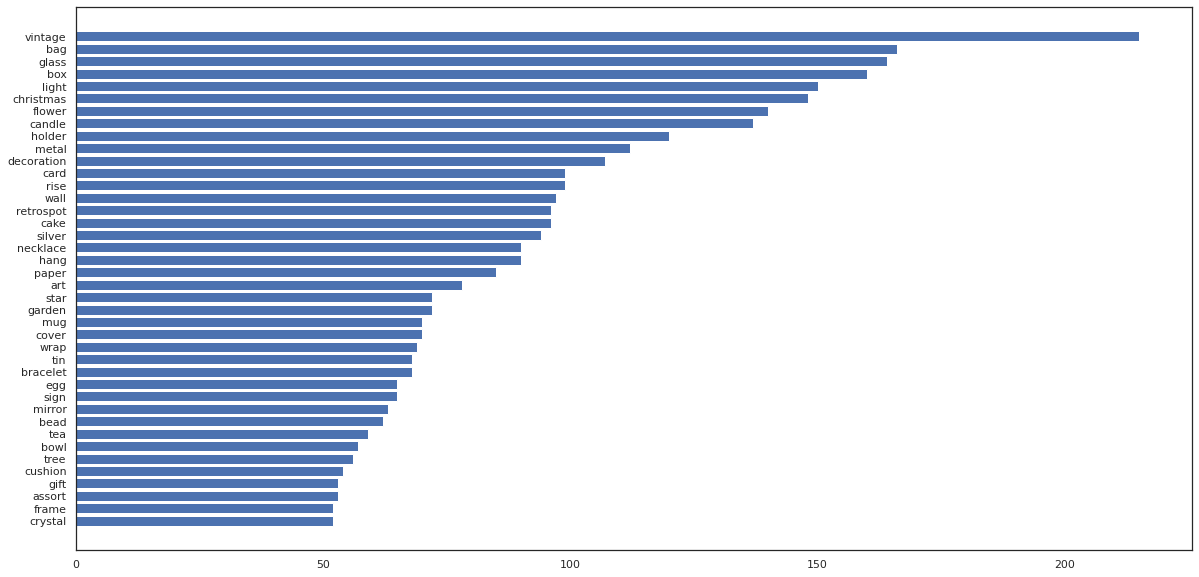

In [30]:
##
## Plotting most frequent words from positive reviews using bar chart
##
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white')
from nltk import FreqDist #function to find the frequent words in the data


#Extracts words into list and count frequency
all_words = ' '.join([text for text in df['description_processed']])
all_words = all_words.split()
words_df = FreqDist(all_words)

# Extracting words and frequency from words_df object
words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})
words_df
# Subsets top 30 words by frequency
words_df = words_df.nlargest(columns="count", n = 40) 

words_df.sort_values('count', inplace = True)

# Plotting 30 frequent words
plt.figure(figsize=(20,10))
ax = plt.barh(words_df['word'], width = words_df['count'])
plt.show()

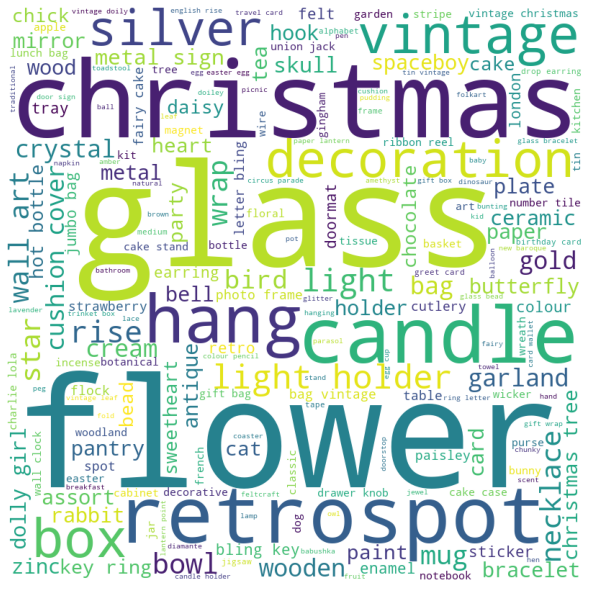

In [31]:
##
## Bilding a Word Cloud
## 
from wordcloud import WordCloud
all_words = ' '.join([text for text in df['description_processed']])
 

wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      min_font_size = 10).generate(all_words)

#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

Bag of words model

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Creating matrix of top 2500 tokens
tfidf = TfidfVectorizer(max_features=2500)
X = tfidf.fit_transform(df.description_processed)
features = tfidf.get_feature_names()
print(len(features))

1696


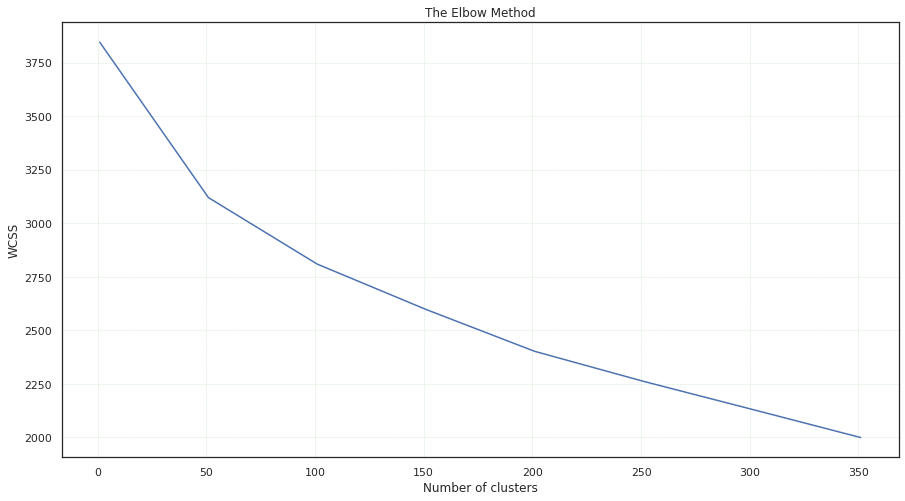

In [33]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,400,50):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.figure(figsize = (15, 8), facecolor = None) 
plt.plot(range(1,400,50),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.grid(which="minor",alpha=0.6,linewidth=0.3)
plt.grid(which="major",alpha=0.2,linewidth=0.3)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.show()

In [34]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=50)
kmeans.fit(X)
cluster=kmeans.labels_

In [35]:
len(kmeans.labels_)

3877

In [36]:
df["description_processed"].shape

(3877,)

In [37]:
df["cluster_value"]=cluster
df[["Description",'description_processed',"cluster_value"]].sample(10)

,Description,description_processed,cluster_value
1498,"FEATHER PEN,COAL BLACK",feather pen coal,5
23378,DROP DIAMANTE EARRINGS BLACK DIAMON,drop diamante earring diamon,30
185873,WRAP BIRD GARDEN,wrap bird garden,44
3082,TOY TIDY SPACEBOY,toy tidy spaceboy,5
6372,36 PENCILS TUBE POSY,pencil tube posy,28
713,RETROSPOT CHILDRENS APRON,retrospot childrens apron,9
13070,FUNKY DIVA PEN,funky diva pen,5
24618,LAVENDER SCENT CAKE CANDLE,lavender scent cake candle,45
611,WICKER STAR,wicker star,24
2328,RAINBOW PEGS PHOTO CLIP STRING,rainbow peg photo clip string,5


In [38]:
# grp=df.groupby(["cluster_value"])["Description"].apply(list)
grp=df.groupby(["cluster_value"])["description_processed"].apply(list)
for i in range(len(grp)):
  print("Group: {:<2} --> {}".format(i, len(grp[i])))

Group: 0  --> 62
Group: 1  --> 61
Group: 2  --> 68
Group: 3  --> 37
Group: 4  --> 124
Group: 5  --> 1196
Group: 6  --> 33
Group: 7  --> 96
Group: 8  --> 47
Group: 9  --> 79
Group: 10 --> 119
Group: 11 --> 25
Group: 12 --> 63
Group: 13 --> 26
Group: 14 --> 68
Group: 15 --> 15
Group: 16 --> 25
Group: 17 --> 32
Group: 18 --> 40
Group: 19 --> 59
Group: 20 --> 41
Group: 21 --> 31
Group: 22 --> 59
Group: 23 --> 88
Group: 24 --> 21
Group: 25 --> 74
Group: 26 --> 72
Group: 27 --> 41
Group: 28 --> 39
Group: 29 --> 34
Group: 30 --> 35
Group: 31 --> 63
Group: 32 --> 80
Group: 33 --> 65
Group: 34 --> 84
Group: 35 --> 42
Group: 36 --> 43
Group: 37 --> 12
Group: 38 --> 22
Group: 39 --> 31
Group: 40 --> 72
Group: 41 --> 35
Group: 42 --> 40
Group: 43 --> 88
Group: 44 --> 39
Group: 45 --> 99
Group: 46 --> 98
Group: 47 --> 24
Group: 48 --> 63
Group: 49 --> 67


In [39]:
#Merge the Cluster_value to the mail table
df_merge = data.merge(df,left_on="Description",right_on="Description")
df_merge.sample(5)

,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,description_processed,cluster_value
108594,22759,SET OF 3 NOTEBOOKS IN PARCEL,12,2011-06-20,1.65,15076,United Kingdom,notebook parcel,17
210265,21216,"SET 3 RETROSPOT TEA,COFFEE,SUGAR",12,2011-08-01,4.25,17053,United Kingdom,retrospot tea coffee sugar,27
288993,22270,HAPPY EASTER HANGING DECORATION,2,2011-09-29,3.75,12937,United Kingdom,happy easter hang decoration,26
66788,22558,CLOTHES PEGS RETROSPOT PACK 24,2,2011-11-01,1.65,14667,United Kingdom,clothes peg retrospot,9
30409,21975,PACK OF 60 DINOSAUR CAKE CASES,24,2011-10-18,0.55,14911,EIRE,dinosaur cake case,25


In [40]:
#since stockcode aligns with description it may not make any difference by deleting it 
df_merge.drop(["Description","description_processed","StockCode"],axis=1,inplace=True)
df_merge["Month"]=df_merge["InvoiceDate"].dt.month
df_merge.sample(10)

,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cluster_value,Month
145645,12,2011-01-31,0.65,18245,United Kingdom,5,1
48317,2,2011-03-30,12.75,17400,United Kingdom,5,3
72141,6,2010-12-14,4.95,16458,United Kingdom,42,12
16247,12,2011-08-31,1.65,12423,Belgium,1,8
226966,10,2011-01-16,0.85,13048,United Kingdom,10,1
121829,12,2011-03-30,1.65,16949,United Kingdom,4,3
51145,3,2011-09-22,7.50,13804,United Kingdom,32,9
285068,1,2011-03-17,3.75,13623,United Kingdom,45,3
223603,1,2011-10-19,4.95,16470,United Kingdom,29,10
343012,2,2011-09-25,7.90,13787,United Kingdom,22,9


In [41]:
df_merge.shape

(392732, 7)

In [42]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392732 entries, 0 to 392731
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Quantity       392732 non-null  int64         
 1   InvoiceDate    392732 non-null  datetime64[ns]
 2   UnitPrice      392732 non-null  float64       
 3   CustomerID     392732 non-null  int64         
 4   Country        392732 non-null  object        
 5   cluster_value  392732 non-null  int32         
 6   Month          392732 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3), object(1)
memory usage: 22.5+ MB


In [ ]:
# grp=df.groupby(["cluster_value"])["description_processed"].apply(list)


In [43]:
#Find the total price and Remove Quantity and Unit price of the product
df_merge["Total_price"]=df_merge["Quantity"]*df_merge["UnitPrice"]
df_merge.sample(10)

,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cluster_value,Month,Total_price
222782,4,2011-09-13,8.50,16081,United Kingdom,22,9,34.00
372800,1,2011-11-16,1.25,17841,United Kingdom,24,11,1.25
204704,24,2011-05-05,0.85,17624,United Kingdom,13,5,20.40
9599,2,2011-10-09,4.25,16380,United Kingdom,5,10,8.50
112648,4,2011-01-05,3.75,15358,United Kingdom,47,1,15.00
150242,1,2011-05-31,9.95,18232,United Kingdom,5,5,9.95
302955,12,2011-10-05,0.85,12828,United Kingdom,7,10,10.20
56406,2,2011-02-10,8.50,17686,United Kingdom,36,2,17.00
368695,144,2011-11-08,0.83,16505,United Kingdom,46,11,119.52
125232,32,2011-03-30,2.10,14646,Netherlands,4,3,67.20


In [44]:
# add=df_merge.groupby("CustomerID")["Country"].unique()
df_2 =df_merge 

In [45]:
# Quantity and unit price is deleted as its product total_price remains as a new column.
df_2.drop(["Quantity","UnitPrice"],axis=1,inplace=True)
df_2.head()

,InvoiceDate,CustomerID,Country,cluster_value,Month,Total_price
0,2010-12-01,17850,United Kingdom,32,12,15.3
1,2010-12-01,17850,United Kingdom,32,12,15.3
2,2010-12-01,17850,United Kingdom,32,12,15.3
3,2010-12-01,17511,United Kingdom,32,12,163.2
4,2010-12-01,13408,United Kingdom,32,12,81.6


In [46]:
len(df_2["Country"].unique())

37

In [47]:
df_2.shape

(392732, 6)

In [51]:
#Checking the Country for CustomerID
for i in df_2.groupby(["CustomerID"])["Country"].unique():
  if len(i) > 1:
    print(i)

['Cyprus' 'Austria']
['Belgium' 'Denmark']
['Belgium' 'Spain']
['Switzerland' 'Australia']
['Denmark' 'Austria']
['Australia' 'Belgium']
['Cyprus' 'Spain']
['Switzerland' 'Cyprus']


In [52]:
#Fee CustomerID has more than one country, mapping the CustomerID with mode value of the class
#Grouping customerID based on country and taking its mode
country_df = df_2.groupby("CustomerID").agg({'Country':pd.Series.mode})
country_df.reset_index()
country_dummy=pd.get_dummies(country_df["Country"])
country_dummy=country_dummy.reset_index()
print(country_dummy.shape)
country_dummy.head()

(4339, 38)


,CustomerID,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,...,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
0,12346,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,12347,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12348,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,12349,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12350,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
#Column Month 
month_df=df_2[['CustomerID','Month']]
pd.get_dummies(month_df["Month"])
month_dummy= pd.get_dummies(month_df, columns = ['Month'])
month_dummy=month_dummy.groupby("CustomerID").agg("sum").astype(int)
month_dummy=month_dummy.reset_index()
print(month_dummy.shape)
month_dummy.head()

(4339, 13)


,CustomerID,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,12346,1,0,0,0,0,0,0,0,0,0,0,0
1,12347,29,0,0,24,0,18,0,22,0,47,0,42
2,12348,6,0,0,5,0,0,0,0,3,0,0,17
3,12349,0,0,0,0,0,0,0,0,0,0,73,0
4,12350,0,17,0,0,0,0,0,0,0,0,0,0


In [53]:
#column cluster_value 
cluster_df=df_2[['CustomerID','cluster_value']]
pd.get_dummies(cluster_df["cluster_value"])
cluster_dummy= pd.get_dummies(cluster_df, columns = ['cluster_value']).astype(int)
cluster_dummy=cluster_dummy.groupby("CustomerID").agg("sum")
cluster_dummy=cluster_dummy.reset_index()
print(cluster_dummy.shape)
cluster_dummy.head()

(4339, 51)


,CustomerID,cluster_value_0,cluster_value_1,cluster_value_2,cluster_value_3,cluster_value_4,cluster_value_5,cluster_value_6,cluster_value_7,cluster_value_8,...,cluster_value_40,cluster_value_41,cluster_value_42,cluster_value_43,cluster_value_44,cluster_value_45,cluster_value_46,cluster_value_47,cluster_value_48,cluster_value_49
0,12346,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,12347,1,9,0,1,8,53,0,1,0,...,4,0,0,13,0,4,3,0,0,0
2,12348,0,0,0,2,0,15,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,12349,0,1,0,1,11,25,2,1,0,...,2,0,0,0,0,0,0,0,0,0
4,12350,3,0,0,0,2,6,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [56]:
#column Total_price
Total_price_df=df_2[['CustomerID','Total_price']]
Total_price=Total_price_df.groupby('CustomerID').agg("mean")
Total_price=Total_price.reset_index()
print(Total_price.shape)
# print(Total_price.isnull().sum())
#Binning Total price
print(Total_price["Total_price"].describe())
Total_price['mean_price_binned'] = pd.cut(Total_price['Total_price'], [0, 13, 18,25,772000], labels=[0,1,2,3])
Total_price.drop("Total_price",axis=1,inplace=True)
Total_price.sample(5)

(4339, 2)
count     4339.000000
mean        68.334729
std       1467.744868
min          0.000000
25%         12.387560
50%         17.745568
75%         24.866214
max      77183.600000
Name: Total_price, dtype: float64


,CustomerID,mean_price_binned
3755,17491,3
3566,17223,0
2706,16033,0
220,12618,1
3225,16747,2


In [59]:
from functools import reduce
frame=[country_dummy,month_dummy,cluster_dummy,Total_price]
final_df = reduce(lambda  left,right: pd.merge(left,right,on=['CustomerID'],
                                            how='outer'), frame)
final_df

,CustomerID,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,...,cluster_value_41,cluster_value_42,cluster_value_43,cluster_value_44,cluster_value_45,cluster_value_46,cluster_value_47,cluster_value_48,cluster_value_49,mean_price_binned
0,12346,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,12347,0,0,0,0,0,0,0,0,0,...,0,0,13,0,4,3,0,0,0,2
2,12348,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3,12349,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,12350,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4334,18280,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4335,18281,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
4336,18282,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4337,18283,0,0,0,0,0,0,0,0,0,...,2,0,17,0,2,27,11,0,0,0


In [60]:
final_df.shape

(4339, 101)

In [61]:
final_df=final_df.dropna()
dff=final_df.copy()
dff.drop("CustomerID",axis=1,inplace=True)
X1=dff

In [62]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X1

array([[-0.04559608, -0.04559608, -0.02147684, ..., -0.15318294,
        -0.09066262,  1.35301607],
       [-0.04559608, -0.04559608, -0.02147684, ..., -0.15318294,
        -0.09066262,  0.46880641],
       [-0.04559608, -0.04559608, -0.02147684, ..., -0.15318294,
        -0.09066262,  1.35301607],
       ...,
       [-0.04559608, -0.04559608, -0.02147684, ..., -0.15318294,
        -0.09066262, -0.41540325],
       [-0.04559608, -0.04559608, -0.02147684, ..., -0.15318294,
        -0.09066262, -1.29961291],
       [-0.04559608, -0.04559608, -0.02147684, ..., -0.15318294,
        -0.09066262,  1.35301607]])

In [ ]:
len(X1)

4338

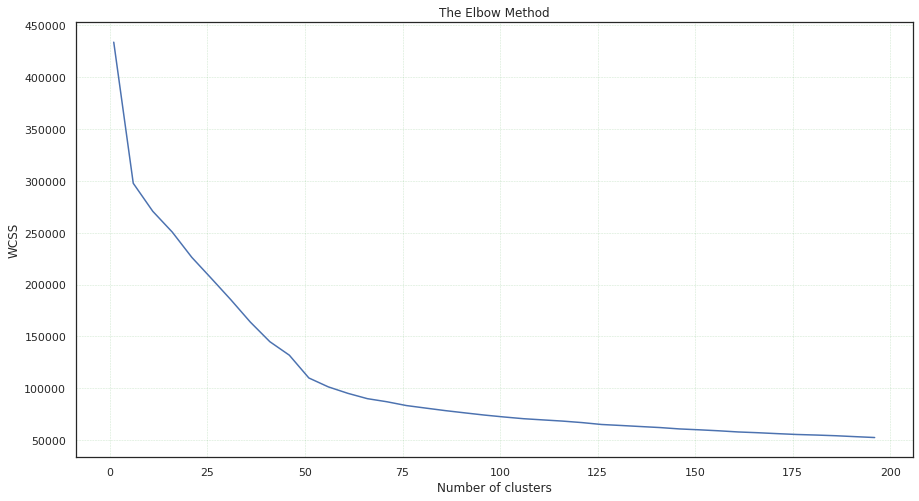

In [63]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,200,5):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(X1)
    wcss.append(kmeans.inertia_)
plt.figure(figsize = (15, 8), facecolor = None) 
plt.plot(range(1,200,5),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.grid(which="minor",alpha=0.6,linewidth=0.3)
plt.grid(which="major",alpha=0.2,linewidth=0.3)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.show()

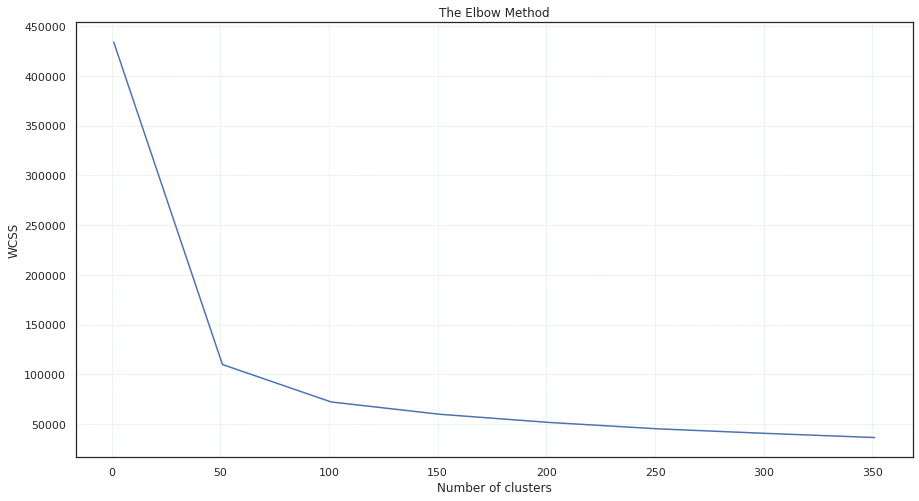

In [64]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,400,50):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(X1)
    wcss.append(kmeans.inertia_)
plt.figure(figsize = (15, 8), facecolor = None) 
plt.plot(range(1,400,50),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.grid(which="minor",alpha=0.6,linewidth=0.3)
plt.grid(which="major",alpha=0.2,linewidth=0.3)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.show()

In [65]:
# Clustering again with k as 50
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=50)
kmeans.fit(X1)
customer_IDcluster=kmeans.labels_

In [66]:
final_df["cluster_no"]=customer_IDcluster
final_df.head()

,CustomerID,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,...,cluster_value_42,cluster_value_43,cluster_value_44,cluster_value_45,cluster_value_46,cluster_value_47,cluster_value_48,cluster_value_49,mean_price_binned,cluster_no
0,12346,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,4
1,12347,0,0,0,0,0,0,0,0,0,...,0,13,0,4,3,0,0,0,2,25
2,12348,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,38
3,12349,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,27
4,12350,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,2,24


In [67]:
#Finally displaying the CustomerID along with their cluster number.
customer_cluster=final_df[["CustomerID","cluster_no"]]
customer_cluster

,CustomerID,cluster_no
0,12346,4
1,12347,25
2,12348,38
3,12349,27
4,12350,24
...,...,...
4334,18280,4
4335,18281,11
4336,18282,11
4337,18283,37
